In [1]:
# Author: C. Hull (github: chat.hull)

# This is a project analyzing historical data of the air quality in Santiago, Chile 

# The data for a representative weather station in central Santiago can be found here:
# https://sinca.mma.gob.cl/index.php/estacion/index/key/D14

# Shout-outs to the many posts/github pages that helped me out!
# Julia Kho: web scraping, https://towardsdatascience.com/how-to-web-scrape-with-python-in-4-minutes-bc49186a8460
# Aditya Sharma: time-series moving averages, https://www.datacamp.com/community/tutorials/moving-averages-in-pandas
# Manish Pathak: concatenating/merging in pandas, https://www.datacamp.com/community/tutorials/joining-dataframes-pandas
# Laura Fedoruk: time-series manipulation in pandas, https://towardsdatascience.com/basic-time-series-manipulation-with-pandas-4432afee64ea
# Facebook Prophet quick-start guide: https://facebook.github.io/prophet/docs/quick_start.html#python-api
# AQI lookup table: http://www.sparetheair.com/publications/AQI_Lookup_Table-PM25.pdf
# AQI calculation: https://metone.com/how-to-calculate-aqi-and-nowcast-indices/

In [2]:
%%javascript

// Prevent scrolling with large/multiple plots
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import requests
from bs4 import BeautifulSoup
import time
from datetime import date
from matplotlib import pyplot as plt
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from sklearn.metrics import mean_squared_error

In [4]:
# Test if a value is a float
def isfloat(x) :
    try:
        float(x)
        return True
    except:
        return False

In [5]:
# Define rms error (RMSE)
def rmse(values1, values2) :
    return np.sqrt( np.nanmean( (np.array(values1)-np.array(values2))**2 ) )

In [6]:
# Calculate AQI value from concentration
def calcAQI(concentration) :    
    if concentration <= 12.0 :
        BP_hi = 12
        BP_lo = 0
        I_hi = 50
        I_lo = 0
    elif 12.0 < concentration <= 35.4 :
        BP_hi = 35.4
        BP_lo = 12.1
        I_hi = 100
        I_lo = 51
    elif 35.4 < concentration <= 55.4 :
        BP_hi = 55.4
        BP_lo = 35.5
        I_hi = 150
        I_lo = 101
    elif 55.4 < concentration <= 150.4 :
        BP_hi = 150.4
        BP_lo = 55.5
        I_hi = 200
        I_lo = 151
    elif 150.4 < concentration <= 250.4 :
        BP_hi = 250.4
        BP_lo = 150.5
        I_hi = 300
        I_lo = 201
    elif 250.4 < concentration <= 350.4 :
        BP_hi = 350.4
        BP_lo = 250.5
        I_hi = 400
        I_lo = 301
    elif 350.4 < concentration <= 500.4 :
        BP_hi = 500.4
        BP_lo = 350.5
        I_hi = 500
        I_lo = 401
    
    return (I_hi-I_lo)/(BP_hi-BP_lo)*(concentration - BP_lo) + I_lo

In [7]:
# Scrape SINCA website

# Many pollutants, but different stations don't have continuous time coverage of all of them
# SO2, NO, NO2, CO, O3, NOX, non-methanic hydrocarbons, PM10, PM2.5

# For now, focus on PM10, PM2.5, and weather data at the Parque O'Higgins station in central Santiago
station = 'D14'
# Earliest common date is 031215 (constrained by weather data)
date_from = '031215'
# Current date
date_to = date.today().strftime("%y%m%d")

#PM2.5
pm25 = {
    'name' : 'pm2.5',
    'url' : 'https://sinca.mma.gob.cl/cgi-bin/APUB-MMA/apub.tsindico2.cgi?outtype=txt&macro=./RM/'+station+'/Cal/PM25//PM25.horario.horario.ic&from='+date_from+'&to='+date_to+'&path=/usr/airviro/data/CONAMA/&lang=esp&rsrc=&macropath='
}

#PM10
pm10 = {
    'name' : 'pm10',
    'url' : 'https://sinca.mma.gob.cl/cgi-bin/APUB-MMA/apub.tsindico2.cgi?outtype=txt&macro=./RM/'+station+'/Cal/PM10//PM10.horario.horario.ic&from='+date_from+'&to='+date_to+'&path=/usr/airviro/data/CONAMA/&lang=esp&rsrc=&macropath='
}

# Relative humidity
rhum = {
    'name' : 'rhum',
    'url' : 'https://sinca.mma.gob.cl/cgi-bin/APUB-MMA/apub.tsindico2.cgi?outtype=txt&macro=./RM/'+station+'/Met/RHUM//horario_000.ic&from='+date_from+'&to='+date_to+'&path=/usr/airviro/data/CONAMA/&lang=esp&rsrc=&macropath='
}

# Temperature
temp = {
    'name' : 'temp',
    'url' : 'https://sinca.mma.gob.cl/cgi-bin/APUB-MMA/apub.tsindico2.cgi?outtype=txt&macro=./RM/'+station+'/Met/TEMP//horario_000.ic&from='+date_from+'&to='+date_to+'&path=/usr/airviro/data/CONAMA/&lang=esp&rsrc=&macropath='
}

# Wind speed
wspd = {
    'name' : 'wspd',
    'url' : 'https://sinca.mma.gob.cl/cgi-bin/APUB-MMA/apub.tsindico2.cgi?outtype=txt&macro=./RM/'+station+'/Met/WSPD//horario_000.ic&from='+date_from+'&to='+date_to+'&path=/usr/airviro/data/CONAMA/&lang=esp&rsrc=&macropath='
}

# Wind direction
wdir = {
    'name' : 'wdir',
    'url' : 'https://sinca.mma.gob.cl/cgi-bin/APUB-MMA/apub.tsindico2.cgi?outtype=txt&macro=./RM/'+station+'/Met/WDIR//horario_000_spec.ic&from='+date_from+'&to='+date_to+'&path=/usr/airviro/data/CONAMA/&lang=esp&rsrc=&macropath='
}

In [8]:
# For testing: print URL of desired variable, paste into browser, and open downloaded data file
#pm25['url']
#pm10['url']
#wspd['url']
#rhum['url']
temp['url']

'https://sinca.mma.gob.cl/cgi-bin/APUB-MMA/apub.tsindico2.cgi?outtype=txt&macro=./RM/D14/Met/TEMP//horario_000.ic&from=031215&to=220127&path=/usr/airviro/data/CONAMA/&lang=esp&rsrc=&macropath='

In [9]:
def scrapeData(series_url) :
    time.sleep(1)
    response = requests.get(series_url)
    print(response)
    return response

def formatData(html_response) :
    data = html_response.text.split('\n')
    # Clear header and footer text
    data = [ line for line in data if len(line) and isfloat(line[0]) ]
    # Non-ideal way of dealing with column numbers in PM data vs. weather data
    data = [ line+' ,' for line in data ]
    # Keep lines with date; time; and validated, preliminary, or non-validated data (latter two are only in PM datasets)
    data = [ line.split(',')[0:5] for line in data if \
             isfloat(line.split(',')[2]) or isfloat(line.split(',')[3]) or isfloat(line.split(',')[4]) ]
    return data

In [10]:
# Empty dataframe; will merge other columns into it one by one
df_tot = pd.DataFrame(columns=['datetime'])

# Scrape and format data, and produce final pandas dataframe
for series in [pm25, pm10, rhum, temp, wspd, wdir] :
    response = scrapeData(series['url'])
    data = formatData(response)
    
    # Format dates
    df = pd.DataFrame.from_records(data, columns=['date', 'time', 'validated', 'preliminary', 'non-validated'])
    df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'], format='%y%m%d %H%M')
    df = df.drop(columns=['date', 'time'])
    
    # Replace white space with NaNs
    df = df.replace(r'^\s+$', np.nan, regex=True)
    # Combine validated, preliminary, and non-validated data columns
    df[series['name']] = df['validated'].combine_first(df['preliminary']).combine_first(df['non-validated'])
    df = df.drop(columns=['validated','preliminary','non-validated'])
    
    # Convert unicode to floats
    df[series['name']] = pd.to_numeric(df[series['name']])
    
    # Merge latest time-series into full DataFrame, resort index
    df_tot = pd.merge(df_tot, df, on='datetime', how='outer')
    df_tot = df_tot.sort_values('datetime')
    df_tot = df_tot.reset_index(drop=True)

<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>


In [11]:
# Strip out ds (datestamp) and pm2.5 (for the y column) for the Prophet prediction
df_prophet = df_tot[['datetime','pm2.5']]
df_prophet = df_prophet.rename(columns={'datetime':'ds', 'pm2.5':'y'})

In [12]:
# Set datetime column as the index of the dataframe
df_tot = df_tot.set_index('datetime')

In [13]:
df_tot.tail()

,pm2.5,pm10,rhum,temp,wspd,wdir
datetime,,,,,,
2022-01-27 10:00:00,14.0,67.0,52.5000,22.0250,1.38607,132.048
2022-01-27 11:00:00,16.0,72.0,48.6667,23.9583,1.70793,111.822
2022-01-27 12:00:00,14.0,71.0,46.3333,25.5000,2.05379,108.754
2022-01-27 13:00:00,17.0,67.0,44.0833,26.4083,2.46381,114.389
2022-01-27 14:00:00,11.0,84.0,43.0833,26.7917,2.93452,123.255


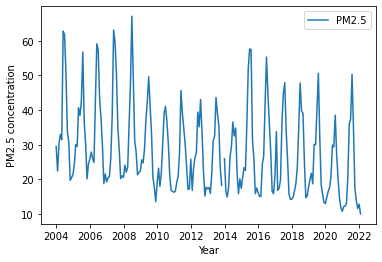

In [14]:
# Sample plot: resampled (monthly) PM2.5 concentration vs. year
##### WE CAN SEE A CLEAR DECREASE AS A FUNCTION OF TIME, 
#####   WITH THE WINTER PEAKS AND SUMMER TROUGHS REGISTERING LOWER VALUES ON AVERAGE.
#####   STRANGELY, THIS IS SOMETHING I HAVE NEVER HEARD ON THE NEWS.  I ASSUME IT'S BECAUSE
#####   EMISSION FROM CARS IS PROGRESSIVELY DECREASING AS OLDER CARS ARE TAKEN OFF THE ROAD.
t_min='2000-01-01'
t_max='2030-01-01'
plt.plot(df_tot['pm2.5'][t_min:t_max].resample('M').mean(),'-', label='PM2.5')
#plt.plot(df_tot['pm10'][t_min:t_max].resample('M').mean(),'-', label='PM10')
#plt.plot(df_tot['temp'][t_min:t_max].resample('M').mean(),'-', label='humidity')
plt.xlabel('Year')
plt.ylabel('PM2.5 concentration')
plt.legend()

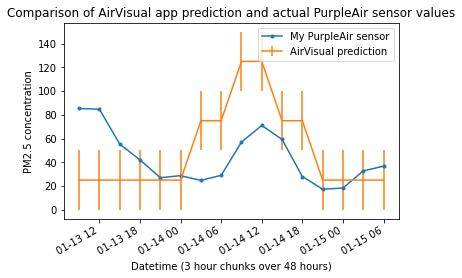

The prediction from the AirVisual app is only correct half of the time, despite having enormous error bars (+-25 in AQI units). It fails to predict the lunchtime peak on 1/13/22, and overpredicts the peak on 1/14/22.


In [15]:
# Test of AirVisual prediction vs. the actual reading of my sensor over a 48-hour period

airVisual = [25,25,25,25,25,25,75,75,125,125,75,75,25,25,25,25]
sensor = [85.3, 84.7, 55.3, 42, 27, 28.7, 24.7, 29, 57, 71, 59.3, 28, 17.3, 18.3, 32.7, 36.7]
dates = pd.date_range(start='2022-01-13 09:00:00', end='2022-01-15 06:00:00', periods=16)

fig, ax = plt.subplots()
ax.plot(dates,sensor, '.-', label='My PurpleAir sensor')
ax.errorbar(dates,airVisual,25,label='AirVisual prediction')
fig.autofmt_xdate()
ax.set_title('Comparison of AirVisual app prediction and actual PurpleAir sensor values')
ax.set_xlabel('Datetime (3 hour chunks over 48 hours)')
ax.set_ylabel('PM2.5 concentration')
ax.legend()
plt.show()

print('The prediction from the AirVisual app is only correct half of the time, despite having enormous error bars (+-25 in AQI units). It fails to predict the lunchtime peak on 1/13/22, and overpredicts the peak on 1/14/22.')

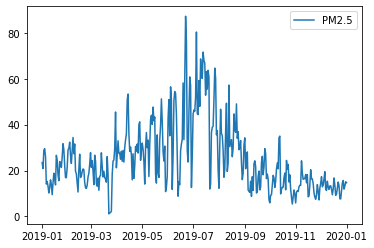

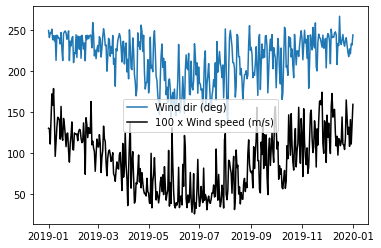

In [16]:
# Sample plots
# Top: resampled (daily) PM2.5 concentration as a function of time in 2019 (pre-pandemic year)
# Bottom: resampled (daily) wind direction (deg) and wind speed (m/s, rescaled by 100x) with the same time range
##### THERE ARE CLEAR CORRELATIONS BETWEEN PM2.5 CONCENTRATION AND BOTH WIND DIRECTION AND WIND SPEED.  
##### IN THE WINTER THE WIND DIES DOWN, AND THUS THE POLLUTION IS NOT BLOWN AWAY.
##### THE CHANGE IN WIND DIRECTION FROM THE WEST=270 DEG IN THE SUMMER VS. THE SOUTH=180 DEG IN THE WINTER
#####    DESERVES FURTHER EXPLORATION.

t_min='2019-01-01'
t_max='2020-01-01'
plt.figure()
plt.plot(df_tot['pm2.5'][t_min:t_max].resample('D').mean(),'-', label='PM2.5')
plt.legend()
plt.figure()
plt.plot(df_tot['wdir'][t_min:t_max].resample('D').mean(),'-', label='Wind dir (deg)')
plt.plot(100*df_tot['wspd'][t_min:t_max].resample('D').mean(),'k-', label='100 x Wind speed (m/s)')
plt.legend()

In [17]:
# Perform a simple prediction of Santiago's AQI using Prophet
# Prophet requires a df (named 'df') with columns named 'ds' (datestamp) and 'y' (numeric measurement to be forecast)
df = df_prophet
df.tail()

,ds,y
158283,2022-01-27 10:00:00,14.0
158284,2022-01-27 11:00:00,16.0
158285,2022-01-27 12:00:00,14.0
158286,2022-01-27 13:00:00,17.0
158287,2022-01-27 14:00:00,11.0


In [18]:
# Instantiate model and fit data (takes 2-3 min)
m = Prophet()
m.fit(df)

Initial log joint probability = -80.0945
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        524508    0.00106863       13707.5           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        524629   0.000604874       8916.88           1           1      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        524693   0.000920629       18217.6      0.6003      0.6003      349   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        524789    0.00853546       15040.4           1           1      466   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        524938    0.00119447       13391.4       1.378      0.1378      576   
    Iter      log prob        ||dx||      ||grad||       alpha  

|dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1199        525285   7.45622e-05       3030.24      0.3892      0.3892     1377   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1299        525289    0.00252157       1936.68           1           1     1483   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1399        525293   0.000262547       3962.51           1           1     1594   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1408        525293   6.52942e-05       505.224           1           1     1606   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [19]:
# Make future df
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
158648,2023-01-23 14:00:00
158649,2023-01-24 14:00:00
158650,2023-01-25 14:00:00
158651,2023-01-26 14:00:00
158652,2023-01-27 14:00:00


In [20]:
# Make forecast (takes 1 minute)
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
158648,2023-01-23 14:00:00,4.197918,-25.156560,32.167906
158649,2023-01-24 14:00:00,6.433743,-20.792650,33.193132
158650,2023-01-25 14:00:00,6.569324,-19.910010,37.030943
158651,2023-01-26 14:00:00,7.356551,-19.476378,36.020981
158652,2023-01-27 14:00:00,7.948769,-20.388355,35.774474


In [21]:
##### These interactive plotly plots seem to make the notebook crash

# Interactive plotly plot of prediction
# plot_plotly(m, forecast)

# For plotting interactive plot of components
# plot_components_plotly(m, forecast)

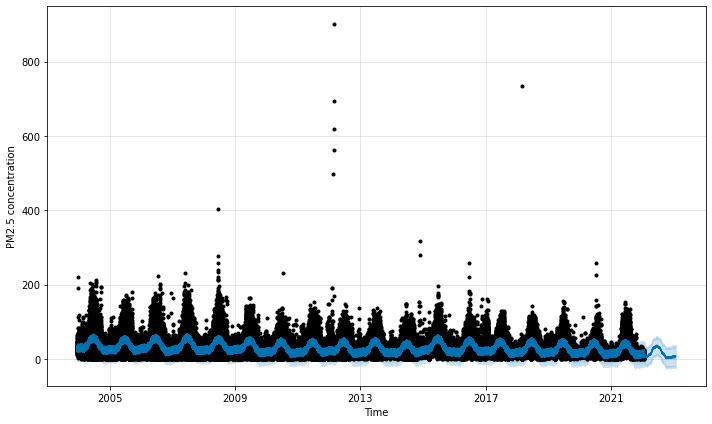

In [22]:
# Static plot of forecast
fig1 = m.plot(forecast, xlabel='Time', ylabel='PM2.5 concentration')

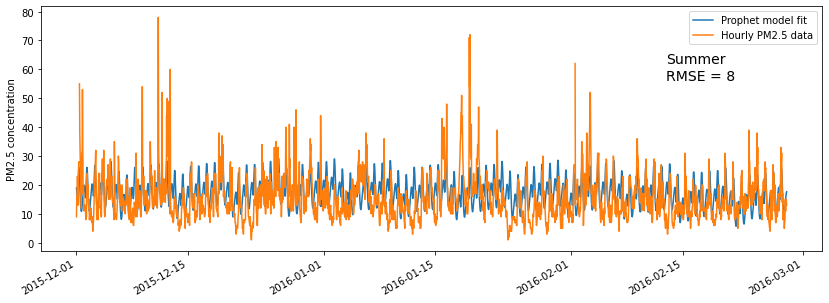

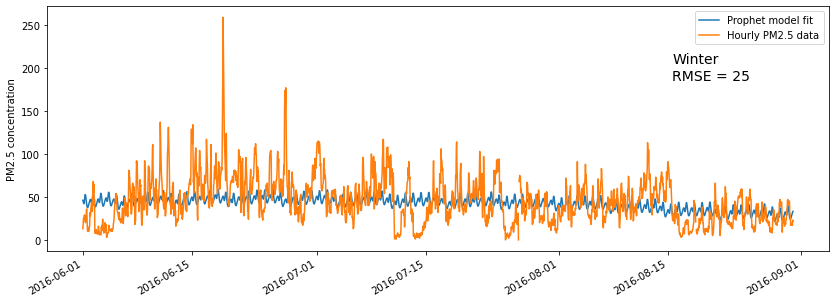

In [23]:
for i,dates in enumerate( [['2015-12-1','2016-2-28'],['2016-6-1','2016-8-31']] ) :
    t_min = dates[0]
    t_max = dates[1]
    # From model
    dates_model = forecast['ds'][(forecast['ds'] > t_min) & (forecast['ds'] <= t_max)]
    values_model = forecast['yhat'][(forecast['ds'] > t_min) & (forecast['ds'] <= t_max)]
    # Actual data
    values = df_tot['pm2.5'][(df_tot.index > t_min) & (df_tot.index <= t_max)]

    # Plot comparison
    fig, ax = plt.subplots(figsize=(14, 5))
    ax.set_ylabel('PM2.5 concentration')
    ax.plot(dates_model,values_model, '-', label='Prophet model fit')
    ax.plot(values, '-', label='Hourly PM2.5 data')
    fig.autofmt_xdate()
    ax.legend()
    
    # Calculate RMSE of values vs. model
    error = rmse(values, values_model)
    
    if i==0 :
        plt.annotate('Summer\nRMSE = {0}'.format(round(error)), xy=(0.8, 0.7), xycoords='axes fraction', fontsize=14)
    elif i==1 :
        plt.annotate('Winter\nRMSE = {0}'.format(round(error)), xy=(0.8, 0.7), xycoords='axes fraction', fontsize=14)
        

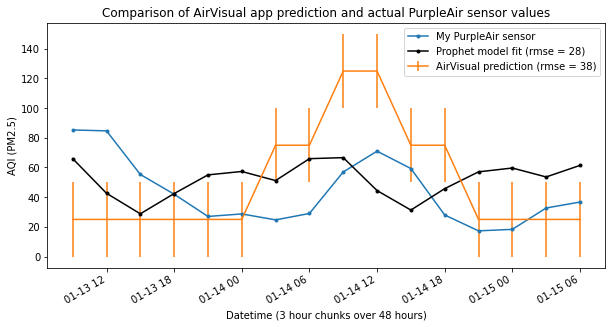

In [24]:
# Test of AirVisual prediction vs. the actual reading of my sensor over a 48-hour period

t_min = '2022-01-13 09:00:00'
t_max = '2022-01-15 06:00:00'
airVisual = [25,25,25,25,25,25,75,75,125,125,75,75,25,25,25,25]
sensor = [85.3, 84.7, 55.3, 42, 27, 28.7, 24.7, 29, 57, 71, 59.3, 28, 17.3, 18.3, 32.7, 36.7]
dates = pd.date_range(start=t_min, end=t_max, periods=16)

# Add the model fit to the plot now
values_model = forecast[['ds','yhat']][(forecast['ds'] >= t_min) & (forecast['ds'] <= t_max)]
values_model = values_model.set_index('ds')
values_model = values_model.resample('3h').mean()
# Convert model values (concentration) to PM2.5 AQI
values_model = [calcAQI(concentration) for concentration in values_model['yhat']]

# Calculate rmse
rmse_airVisual = round(rmse(sensor,airVisual))
rmse_model = round(rmse(sensor,values_model))

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(dates,sensor, '.-', label='My PurpleAir sensor')
ax.errorbar(dates,airVisual,25,label='AirVisual prediction (rmse = {0})'.format(rmse_airVisual))
ax.plot(dates,values_model, 'k.-', label='Prophet model fit (rmse = {0})'.format(rmse_model))
fig.autofmt_xdate()
ax.set_title('Comparison of AirVisual app prediction and actual PurpleAir sensor values')
ax.set_xlabel('Datetime (3 hour chunks over 48 hours)')
ax.set_ylabel('AQI (PM2.5)')
ax.legend()
plt.show()

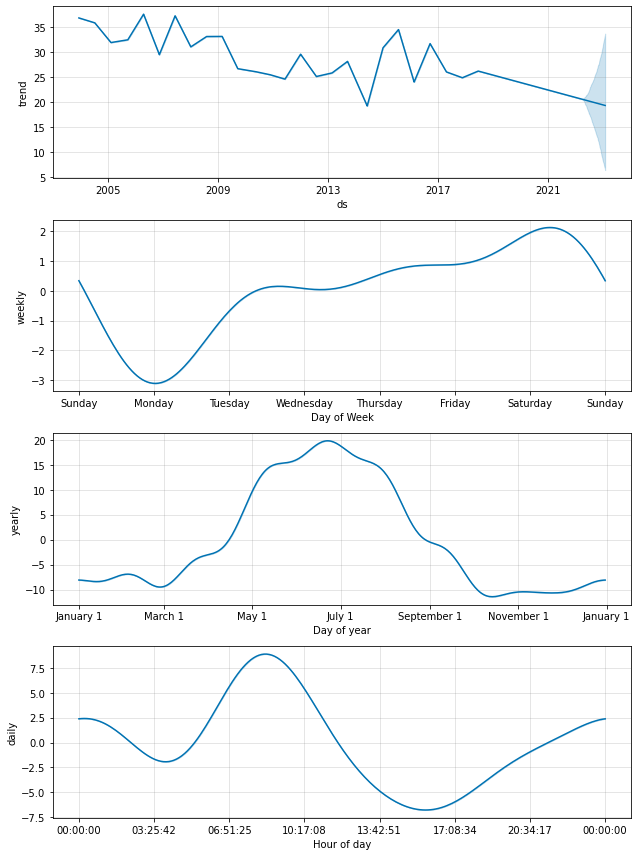

In [25]:
# Static plot of components
fig2 = m.plot_components(forecast)

In [26]:
# TO DO: 
# Use the Prophet model to predict part of the existing Santiago data and calculate RMSE
    # Train using 2003-2017; predict 2018-present 
    # Check RMSE in 2018,2019 vs. 2020,2021 (i.e., does the model predict the values in the pandemic years?)
# Remove the annual, weekly, and daily signals and search for anomalies (can I pull out the BBQs from the downstairs neighbors?)
# Go beyond the Prophet model and include all of the Santiago data (PM2.5, PM10, temp, pressure humidity, wind speed, wind dir) vs. just some of it (e.g., removing wspd and wdir) to see which variables provide better predictive power.
